# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

**Инструкция по выполнению проекта**

1. Загрузите и подготовьте данные.
2. Обучите разные модели. 
3. Сделайте выводы.

Для выполнения проекта применять *BERT* необязательно, но вы можете попробовать.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import re
import sys
import spacy 

from keras import models, layers, optimizers

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import f1_score
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier

from nltk.corpus import stopwords as nltk_stopwords

In [2]:
plt.style.use("seaborn-v0_8-whitegrid")
tqdm.pandas()
sys.setrecursionlimit(50000)
pd.options.mode.chained_assignment = None

In [3]:
df = pd.read_csv('toxic_comments.csv', index_col=0)

In [4]:
df.sample(10)

,text,toxic
57419,You're asking for original research. (not allo...,0
19154,"""\n\nYou seem quite knowledgeable about the ar...",0
147276,Good to read your reply. I re-checked the tal...,0
78784,"""attacks and edit warring|harassment, personal...",0
122952,. And then we would have to believe that the E...,1
41893,"""\n\n""""Katara""""\nI've removed the section enti...",0
104486,countries not included \n\nsome of the countri...,0
28346,"""Deerfield and NIMBYism ==\n\nHi Mike. While t...",0
65477,"""\n If you disagree with policy, the proper ve...",0
141170,I really need your reply at the end of #Rename...,0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 159292 entries, 0 to 159450
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159292 non-null  object
 1   toxic   159292 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.6+ MB


У нас имеется 159292 столбцов без пропусков

In [6]:
df['text'] = df['text'].astype('U')

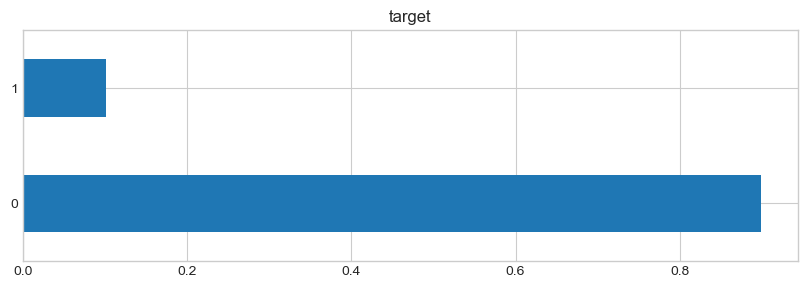

In [7]:
df['toxic'].value_counts(normalize=True).plot(kind='barh', figsize=(10,3), title='target');

**Вывод**    
Датасет состоист из 159292 строк. Пропуски отсутствуют. Предстоит немного предобработать текст.
Имеется дисбаланс классов, надо помнить об этом во время обучения нейронной сети

## Обработка текста

In [8]:
nlp = spacy.load('en_core_web_sm')

def text_token(text):
    text = re.sub(r'[^a-zA-Z]', ' ', text) 
    text = ' '.join([word.lower() for word in text.split()])
    text = ' '.join([token.lemma_ for token in nlp(text)])
    return text

In [9]:
df['lem_text'] = df['text'].progress_apply(text_token)

100%|██████████████████████████████████████████████████████████████████████████| 159292/159292 [37:05<00:00, 71.58it/s]


Проверим как отработала функция и посмотрим несколько результатов

In [10]:
df['text'][20] 

'"\n\n Regarding your recent edits \n\nOnce again, please read WP:FILMPLOT before editing any more film articles.  Your edits are simply not good, with entirely too many unnecessary details and very bad writing.  Please stop before you do further damage. -\'\'\'\'\'\'The \'45 "'

In [11]:
df['lem_text'][20]

'regard your recent edit once again please read wp filmplot before edit any more film article your edit be simply not good with entirely too many unnecessary detail and very bad writing please stop before you do far damage the'

Сохраним созданный датасет, что бы в будущем нам не приходилось ждать по 30 минут перезапуская лематизацию

In [12]:
df.to_csv('lema_text', sep='\t', encoding='utf-8')

In [13]:
df = pd.read_csv('lema_text.csv', sep='\t', encoding='utf-8', index_col = 0)

Посмотрим на самые популярные слова в токсичных и не токсичных сообщениях

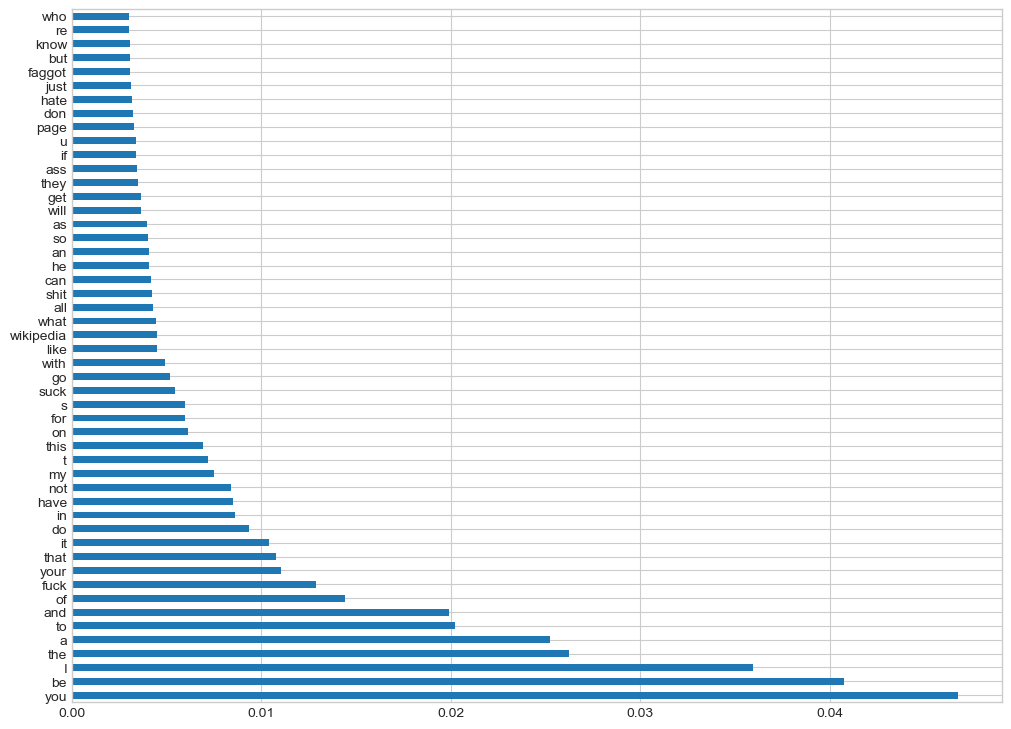

In [14]:
df.loc[df['toxic']==1, 'lem_text'].str.split(expand=True).stack().value_counts(normalize=True).head(50).plot(kind='barh', figsize=(12,9));

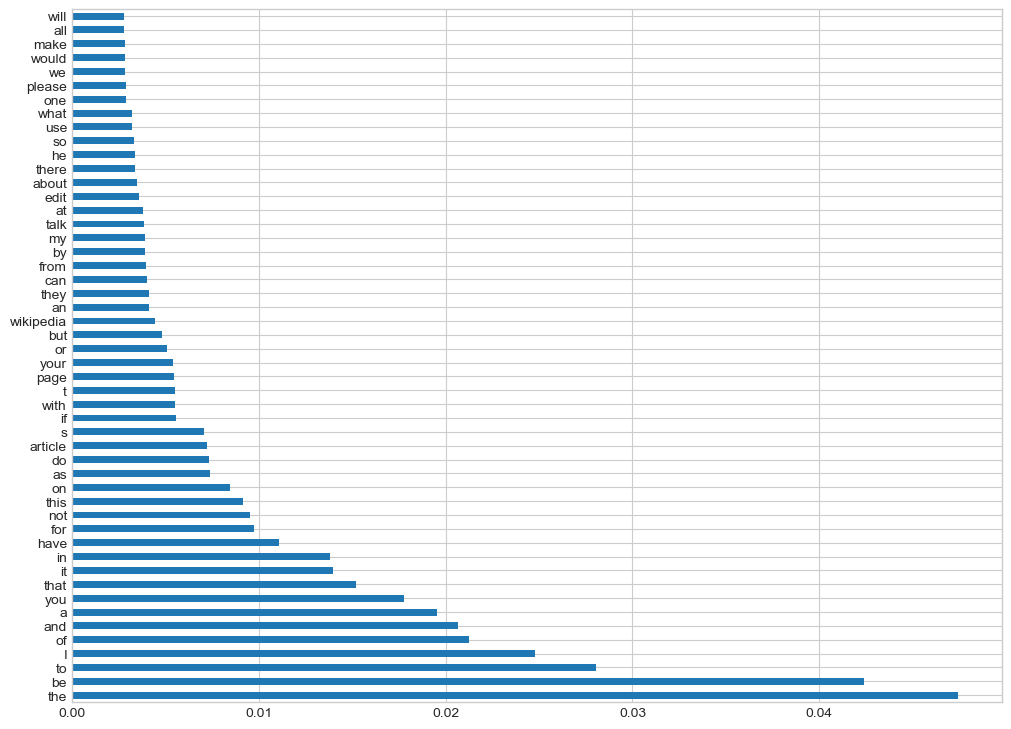

In [15]:
df.loc[df['toxic']==0, 'lem_text'].str.split(expand=True).stack().value_counts(normalize=True).head(50).plot(kind='barh', figsize=(12,9));

В токсичных сообщениях очень много ругательств *логично*, но то что в токсик сообщениях есть википедия это меня удивило

In [16]:
df.isna().sum() # проверка как прошла лематизация

text         0
toxic        0
lem_text    11
dtype: int64

Посмотрим на сооьщения у которых после лематизации появился пропуски

In [17]:
df.loc[df['lem_text'].isna(), ['text', 'toxic']] 

,text,toxic
4475,1993\n\n1994\n\n1995\n\n1996\n\n1997\n\n1998\n...,0
6293,193.61.111.53 15:00,0
10206,"64.86.141.133""",0
17297,~ \n\n68.193.147.157,0
38792,"88.104.31.21""",0
52393,"14:53,",0
53740,92.24.199.233|92.24.199.233]],0
61711,"""\n\n 199.209.144.211 """,0
82619,"""\n '''''' 2010/2013 """,0
119123,"""""""",1


Делаю вывод, что эти сообщения не несут информации и потому мы можем их удалить

In [18]:
df.dropna(inplace=True)

In [19]:
df.isna().sum()

text        0
toxic       0
lem_text    0
dtype: int64

**Вывод**    
У нас получилось немного почистить текст от мусора. Теперь предстоит представить сообщения в виде векторного пространства

## Разбиение на train test + tf_idf

In [20]:
target = df['toxic'].copy()
features = df['lem_text'].copy()

In [21]:
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.33, random_state=74830, stratify=target)

In [22]:
for x,y,z in zip((target_train, target_test),(features_train, features_test), ('тренировочной', 'тестовой')):
    print(f'В {z} выборке, размеры матрицы признаков  = {y.shape}, целевого признака = {x.shape}')   

В тренировочной выборке, размеры матрицы признаков  = (106718,), целевого признака = (106718,)
В тестовой выборке, размеры матрицы признаков  = (52563,), целевого признака = (52563,)


In [23]:
target_test.value_counts(normalize=True)

0    0.898389
1    0.101611
Name: toxic, dtype: float64

In [24]:
target_train.value_counts(normalize=True)

0    0.898386
1    0.101614
Name: toxic, dtype: float64

Применим TF-IDF к нашим признакам

## RandomForest

In [25]:
pipe_RF = Pipeline([('tf_idf', TfidfVectorizer(stop_words=list(nltk_stopwords.words('english')), ngram_range=(1, 3))),
                    ('model', RandomForestClassifier(random_state=3819, class_weight='balanced'))])

parametrs_RF = {'model__n_estimators': range(200, 301, 100), 
                'model__max_depth': range(3,5)}

In [26]:
rf_gs = GridSearchCV(pipe_RF, param_grid=parametrs_RF, scoring='f1', cv = 3, verbose = 5)

In [27]:
rf_gs.fit(features_train, target_train)

Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV 1/3] END model__max_depth=3, model__n_estimators=200;, score=0.293 total time=  47.2s
[CV 2/3] END model__max_depth=3, model__n_estimators=200;, score=0.298 total time=  47.5s
[CV 3/3] END model__max_depth=3, model__n_estimators=200;, score=0.271 total time=  47.8s
[CV 1/3] END model__max_depth=3, model__n_estimators=300;, score=0.300 total time=  55.9s
[CV 2/3] END model__max_depth=3, model__n_estimators=300;, score=0.291 total time=  58.3s
[CV 3/3] END model__max_depth=3, model__n_estimators=300;, score=0.291 total time=  55.7s
[CV 1/3] END model__max_depth=4, model__n_estimators=200;, score=0.301 total time=  48.5s
[CV 2/3] END model__max_depth=4, model__n_estimators=200;, score=0.296 total time=  50.1s
[CV 3/3] END model__max_depth=4, model__n_estimators=200;, score=0.278 total time=  47.4s
[CV 1/3] END model__max_depth=4, model__n_estimators=300;, score=0.308 total time=  58.2s
[CV 2/3] END model__max_depth=4, model__

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('tf_idf',
                                        TfidfVectorizer(ngram_range=(1, 3),
                                                        stop_words=['i', 'me',
                                                                    'my',
                                                                    'myself',
                                                                    'we', 'our',
                                                                    'ours',
                                                                    'ourselves',
                                                                    'you',
                                                                    "you're",
                                                                    "you've",
                                                                    "you'll",
                                                                    "you'd",
                                                                    'your',
                                                                    'yours',
                                                                    'yourself',
                                                                    'yourselves',
                                                                    'he', 'him',
                                                                    'his',
                                                                    'himself',
                                                                    'she',
                                                                    "she's",
                                                                    'her',
                                                                    'hers',
                                                                    'herself',
                                                                    'it',
                                                                    "it's",
                                                                    'its',
                                                                    'itself', ...])),
                                       ('model',
                                        RandomForestClassifier(class_weight='balanced',
                                                               random_state=3819))]),
             param_grid={'model__max_depth': range(3, 5),
                         'model__n_estimators': range(200, 301, 100)},
             scoring='f1', verbose=5)

In [28]:
result = pd.DataFrame({'модель':['Случайный лес'], 'f1_score': [rf_gs.best_score_]})
result

,модель,f1_score
0,Случайный лес,0.297714


## LogisticRegression

In [29]:
pipe_LR = Pipeline([('tf_idf', TfidfVectorizer(stop_words=list(nltk_stopwords.words('english')), ngram_range=(1, 3))),
                    ('model', LogisticRegression(class_weight='balanced', max_iter=1000))])

parametrs_LR = {'model__C': [1, 0.1, 0.01]}

In [30]:
lr_gs  = GridSearchCV(pipe_LR, param_grid=parametrs_LR, cv = 3, verbose = 5,  scoring='f1')

In [31]:
lr_gs.fit(features_train, target_train)

Fitting 3 folds for each of 3 candidates, totalling 9 fits
[CV 1/3] END ........................model__C=1;, score=0.735 total time= 1.3min
[CV 2/3] END ........................model__C=1;, score=0.729 total time=  59.8s
[CV 3/3] END ........................model__C=1;, score=0.731 total time= 1.4min
[CV 1/3] END ......................model__C=0.1;, score=0.693 total time=  55.4s
[CV 2/3] END ......................model__C=0.1;, score=0.690 total time=  52.4s
[CV 3/3] END ......................model__C=0.1;, score=0.687 total time=  54.6s
[CV 1/3] END .....................model__C=0.01;, score=0.698 total time=  42.1s
[CV 2/3] END .....................model__C=0.01;, score=0.693 total time=  41.4s
[CV 3/3] END .....................model__C=0.01;, score=0.693 total time=  41.2s


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('tf_idf',
                                        TfidfVectorizer(ngram_range=(1, 3),
                                                        stop_words=['i', 'me',
                                                                    'my',
                                                                    'myself',
                                                                    'we', 'our',
                                                                    'ours',
                                                                    'ourselves',
                                                                    'you',
                                                                    "you're",
                                                                    "you've",
                                                                    "you'll",
                                                                    "you'd",
                                                                    'your',
                                                                    'yours',
                                                                    'yourself',
                                                                    'yourselves',
                                                                    'he', 'him',
                                                                    'his',
                                                                    'himself',
                                                                    'she',
                                                                    "she's",
                                                                    'her',
                                                                    'hers',
                                                                    'herself',
                                                                    'it',
                                                                    "it's",
                                                                    'its',
                                                                    'itself', ...])),
                                       ('model',
                                        LogisticRegression(class_weight='balanced',
                                                           max_iter=1000))]),
             param_grid={'model__C': [1, 0.1, 0.01]}, scoring='f1', verbose=5)

In [32]:
result1 = pd.DataFrame({'модель':['Логистическая регрессия'], 'f1_score': [lr_gs.best_score_]})
result = pd.concat([result, result1], axis = 0)
result.reset_index(drop=True, inplace=True)
result

,модель,f1_score
0,Случайный лес,0.297714
1,Логистическая регрессия,0.731642


## LGBMClassifier

In [33]:
pipe_LGBM = Pipeline(steps=[('tf_idf', TfidfVectorizer(stop_words=list(nltk_stopwords.words('english')), ngram_range=(1, 3))),
                            ('model', LGBMClassifier(random_state=3213, class_weight ='balanced'))])

parametrs_LGBM = {'model__n_estimators': range(200, 301, 100)}

In [34]:
lgmb_gs = GridSearchCV(pipe_LGBM, param_grid=parametrs_LGBM, cv = 3, verbose = 5,  scoring='f1')

In [35]:
lgmb_gs.fit(features_train, target_train)

Fitting 3 folds for each of 2 candidates, totalling 6 fits
[CV 1/3] END ...........model__n_estimators=200;, score=0.751 total time= 1.5min
[CV 2/3] END ...........model__n_estimators=200;, score=0.749 total time= 1.5min
[CV 3/3] END ...........model__n_estimators=200;, score=0.741 total time= 1.5min
[CV 1/3] END ...........model__n_estimators=300;, score=0.764 total time= 1.8min
[CV 2/3] END ...........model__n_estimators=300;, score=0.755 total time= 1.8min
[CV 3/3] END ...........model__n_estimators=300;, score=0.755 total time= 1.8min


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('tf_idf',
                                        TfidfVectorizer(ngram_range=(1, 3),
                                                        stop_words=['i', 'me',
                                                                    'my',
                                                                    'myself',
                                                                    'we', 'our',
                                                                    'ours',
                                                                    'ourselves',
                                                                    'you',
                                                                    "you're",
                                                                    "you've",
                                                                    "you'll",
                                                                    "you'd",
                                                                    'your',
                                                                    'yours',
                                                                    'yourself',
                                                                    'yourselves',
                                                                    'he', 'him',
                                                                    'his',
                                                                    'himself',
                                                                    'she',
                                                                    "she's",
                                                                    'her',
                                                                    'hers',
                                                                    'herself',
                                                                    'it',
                                                                    "it's",
                                                                    'its',
                                                                    'itself', ...])),
                                       ('model',
                                        LGBMClassifier(class_weight='balanced',
                                                       random_state=3213))]),
             param_grid={'model__n_estimators': range(200, 301, 100)},
             scoring='f1', verbose=5)

In [36]:
result1 = pd.DataFrame({'модель':['Градиентный бустинг'], 'f1_score': [lgmb_gs.best_score_]})
result = pd.concat([result, result1], axis = 0)
result.reset_index(drop=True, inplace=True)
result

,модель,f1_score
0,Случайный лес,0.297714
1,Логистическая регрессия,0.731642
2,Градиентный бустинг,0.758211


**Вывод**    
Логистическая регрессия и градиентный бустинг показали на тренировочной выборке лучший результат нежели чем случайный лес. 
Но качество не достаточное, потому попробую применить небольшую нейронную сеть и посмотреть её результат

## KERAS

In [38]:
count = CountVectorizer(stop_words=nltk_stopwords.words('english'))

In [39]:
features_train = count.fit_transform(features_train)
features_test = count.transform(features_test)

In [40]:
features_test = features_test.astype(np.int8).toarray()

In [41]:
features_train = features_train.astype(np.int8).toarray()

In [43]:
model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(features_train.shape[1],)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [44]:
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

In [45]:
history = model.fit(features_train, target_train, epochs=3, batch_size=512, validation_split=0.2)

Epoch 1/3
167/167 [==============================] - 114s 652ms/step - loss: 0.2319 - accuracy: 0.9359 - val_loss: 0.1671 - val_accuracy: 0.9543
Epoch 2/3
167/167 [==============================] - 89s 532ms/step - loss: 0.1263 - accuracy: 0.9629 - val_loss: 0.1492 - val_accuracy: 0.9578
Epoch 3/3
167/167 [==============================] - 72s 432ms/step - loss: 0.0906 - accuracy: 0.9715 - val_loss: 0.1448 - val_accuracy: 0.9581


In [47]:
answer = model.predict(features_train)

3335/3335 [==============================] - 101s 28ms/step


In [48]:
answer = [1 if i >=0.5 else 0 for i in answer ]

In [49]:
f1_score(answer, target_train)

0.8744911804613297

Видим, что точность у небольшой нейронной сети для данной задачи достаточная, можно применить её на тестовой выборке

In [50]:
answer = model.predict(features_test)

1643/1643 [==============================] - 50s 25ms/step


In [51]:
answer = [1 if i >= 0.5 else 0 for i in answer]

In [52]:
f1_score(answer, target_test)

0.7832422586520947

## Выводы

Был выдан датасет с 159292 строками и двумя столбцами. `text` - признак, состоящий из сообщения пользователя. `toxic` -  целевой признак, содержащий разметку о токсичности данного сообщения.  

В ходе работы были немного обработаны сообщения при помощи регулярных выражений и слова были лемматизированы и приведены все буквы к нижнему регистру. 

Датасет был разбит на обучающую и тестовую выборку. Затем векторизация текста была сделана при помощи TF-IDF + были удалены стоп слова 

Обучение происходило на моделях `случайный лес`, `логистическая регрессия`, `градиентный бустинг`. 
Что бы часть выборки не превращать в валидационную применялся метод кросс-валидации. 

В результате лучше всего на кросс-валидации показала себя небольшая нейронная модель 

Проверив модель на тестовой выборке удалось получить метрику `f1_score` = 0.7832422586520947

